In [1]:
import numpy as np
import time
import os
import shutil

import random
import pandas as pd

from pylab import *
import matplotlib.pyplot as plt
# from matplotlib_venn import *
%matplotlib inline
import seaborn as sns

from scipy import stats
from numpy.random import *

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import statsmodels.stats.multitest 

# import data

In [2]:
datadir = "../data/"
outdir = "../result/"


In [3]:
df_anno = pd.read_csv(datadir+"epic_anno.csv.gz", index_col=0, skiprows=7)
df_samples = pd.read_csv(datadir+"sample_info/4data_clin_age.csv",index_col=0)


/var/folders/8z/hm83kqdj4wq6jxvn_2rnzlp00000gn/T/ipykernel_6713/347374453.py:1: DtypeWarning: Columns (2,4,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df_anno = pd.read_csv(datadir+"epic_anno.csv.gz", index_col=0, skiprows=7)


FileNotFoundError: [Errno 2] No such file or directory: '../data/sample_info/4data_clin_age.csv'

In [4]:
df_samples = pd.read_csv(datadir+"sample_info/4data_clin_age.csv",index_col=0)
df_samples.head()

,class,dataset,stage,MYCN,event/not,relapse/otherevent/not,alive/death,Event_Free_Survival_Time_in_Days,Overall_Survival_Time_in_Days,FirstEvent,diag_class,diag_age
ID,,,,,,,,,,,,
TARGET-30-PAIFXV-01A-01D,4Noamp,Target,4,N,Event,Event,D,630.0,1114.0,death of disease,1,2004
TARGET-30-PAIPGU-01A-01D,4Noamp,Target,4,N,Event,Death,D,436.0,436.0,death of disease,1,898
TARGET-30-PAISNS-01A-01D,4Noamp,Target,4,N,Event,Event,D,410.0,421.0,death of disease,1,1070
TARGET-30-PAITCI-01A-01D,4Noamp,Target,4,N,Event,Event,D,232.0,324.0,death of disease,1,728
TARGET-30-PAIVHE-01A-01D,4Noamp,Target,4,N,Event,Event,D,672.0,1605.0,death of disease,1,1123


# 1000 replicate were required

# fig 2A

make "true_count_bysample.tsv" 

In [7]:
df = pd.read_csv(datadir+"true_count_bysample.tsv", header=None, sep="\t")
df.columns = ["ID", "selected", "True", "Prob", "MYCNA", "4s", "other", "4", "Class"]
df

,ID,selected,True,Prob,MYCNA,4s,other,4,Class
0,TARGET-30-PAIFXV-01A-01D,298,298,1.0,0,0,0,298,4
1,TARGET-30-PAIPGU-01A-01D,284,284,1.0,0,0,0,284,4
2,TARGET-30-PAISNS-01A-01D,299,299,1.0,0,0,0,299,4
3,TARGET-30-PAITCI-01A-01D,308,308,1.0,0,0,0,308,4
4,TARGET-30-PAIVHE-01A-01D,287,287,1.0,0,0,0,287,4
...,...,...,...,...,...,...,...,...,...
488,GSM3407024,311,311,1.0,0,0,311,0,other
489,GSM3407025,294,294,1.0,0,0,0,294,4
490,GSM3407026,304,304,1.0,0,0,304,0,other
491,GSM3407027,304,304,1.0,304,0,0,0,MYCNA


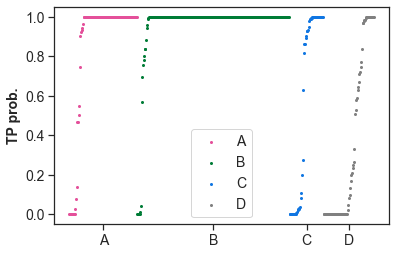

In [8]:
sns.set(font="Arial")
sns.set_style('ticks')

df_sort = df.sort_values("Prob", ascending=True).reset_index(drop=True)
df_sort
offset = 0
offset_ticks = []
labels = ["A","B","C","D"]
i=0
plt_cols = {"MYCNA":"#e4509a","4":"#007c36","4s":"#1076e2","other":"gray"}

for k in ["MYCNA","4","4s","other"]:
    df_tmp = df_sort.loc[df_sort["Class"]==k]
    plt.scatter(range(offset, offset+df_tmp.shape[0]), df_tmp["Prob"], s=4, label=labels[i], color=plt_cols[k])
    i += 1
    offset_ticks.append(offset+df_tmp.shape[0]/2)
    offset += df_tmp.shape[0]
    
# plt.xlabel("Lifetime", fontweight="bold", fontsize=18)
plt.ylabel("TP prob.", fontweight="bold", fontsize=14)
plt.xticks(offset_ticks,labels,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig(outdir+"KM_TP_ratio.pdf", bbox_inches='tight', pad_inches=0)

### fig 2B

In [9]:
df_misclass = df.loc[(df["Class"]=="other") & (df["Prob"]<0.5)]
print("df_misclass: class=other,plob<0.5",df_misclass.shape)
df_misclass = df.loc[(df["Class"]=="other") & (df["4"]>170)]
print("df_misclass: class=other,pred[4]>170",df_misclass.shape)
df_trueclass = df.loc[(df["Class"]=="other") & (df["other"]>150)]
print("df_trueclass: class=other,pred[other]>150",df_trueclass.shape)
df_4class=df.loc[(df["Class"]=="4") & (df["4"]>150)]
print("df_4class: class=4,pred[4]>150",df_4class.shape)

df_misclass: class=other,plob<0.5 (51, 9)
df_misclass: class=other,pred[4]>170 (35, 9)
df_trueclass: class=other,pred[other]>150 (31, 9)
df_4class: class=4,pred[4]>150 (239, 9)


In [11]:
df_misclass["ID"].to_csv(datadir+"class/df_misclass.txt", index=None)
df_trueclass["ID"].to_csv(datadir+"class/df_trueclass.txt", index=None)

In [13]:
df_D1 = pd.read_csv(datadir+"class/df_misclass.txt",header=None)
df_D2 = pd.read_csv(datadir+"class/df_trueclass.txt",header=None)


In [15]:
df_D1_tmp = pd.DataFrame()
for i,items in df_D1.iterrows():
    if items[0] not in df_samples.index:
        continue
    for k in df_samples.columns:
        df_D1_tmp.at[items[0], k] = df_samples.at[items[0], k]

df_D1_tmp.to_csv(datadir+"class/df_D1_anno.txt")

In [16]:
df_D2_tmp = pd.DataFrame()
for i,items in df_D2.iterrows():
    if items[0] not in df_samples.index:
        continue
    for k in df_samples.columns:
        df_D2_tmp.at[items[0], k] = df_samples.at[items[0], k]

df_D2_tmp.to_csv(datadir+"class/df_D2_anno.txt")

### fig 2C

(25, 10) (29, 10) (197, 10)


/var/folders/8z/hm83kqdj4wq6jxvn_2rnzlp00000gn/T/ipykernel_2389/3304012717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_A.loc[~data_A["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_A["Event_Free_Survival_Time_in_Days"].astype(float)
/var/folders/8z/hm83kqdj4wq6jxvn_2rnzlp00000gn/T/ipykernel_2389/3304012717.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_B.loc[~data_B["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_B["Event_Free_Survival_Time_in_Days"].astype(float)
/var/folders/8z/hm83kqdj4wq6jxvn_2rnzlp00000gn/T/i

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.76 0.01      7.54

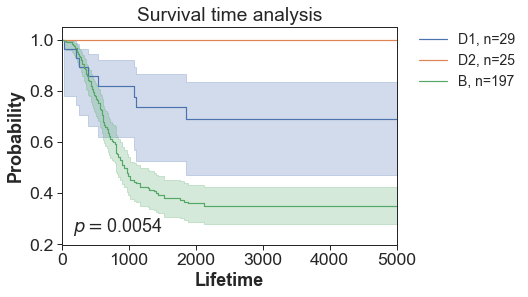

In [21]:
sns.set_style('ticks')
sns.set_context('paper', 2)

kmf = KaplanMeierFitter()

ax = None

data_A = df_surv.loc[(df_surv.index.isin(df_trueclass["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"] != "-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]
data_B = df_surv.loc[(df_surv.index.isin(df_misclass["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"] != "-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]
data_C = df_surv.loc[(df_surv.index.isin(df_4class["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"] != "-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]
print (data_A.shape,data_B.shape,data_C.shape)

data_A.loc[~data_A["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_A["Event_Free_Survival_Time_in_Days"].astype(float)
data_B.loc[~data_B["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_B["Event_Free_Survival_Time_in_Days"].astype(float)
data_C.loc[~data_C["Event_Free_Survival_Time_in_Days"].isnull(), "Event_Free_Survival_Time_in_Days"] = data_C["Event_Free_Survival_Time_in_Days"].astype(float)

# data_A["Event_Free_Survival_Time_in_Days"] = data_A["Event_Free_Survival_Time_in_Days"].astype(float)
# data_B["Event_Free_Survival_Time_in_Days"] = data_B["Event_Free_Survival_Time_in_Days"].astype(float)
# data_C["Event_Free_Survival_Time_in_Days"] = data_C["Event_Free_Survival_Time_in_Days"].astype(float)

data_B.loc[data_B["alive/death"] == "D", "event"] = 1
data_B.loc[data_B["alive/death"] == "A", "event"] = 0
kmf.fit(data_B["Event_Free_Survival_Time_in_Days"], data_B["event"], label="D1, n="+str(len(data_B)))
# kmf.fit(data_B["Event_Free_Survival_Time_in_Days"], data_B["event"], label="D1")

ax = kmf.plot(ax=ax)

data_A.loc[data_A["alive/death"] == "D", "event"] = 1
data_A.loc[data_A["alive/death"] == "A", "event"] = 0
kmf.fit(data_A["Event_Free_Survival_Time_in_Days"], data_A["event"], label="D2, n="+str(len(data_A)))
# kmf.fit(data_A["Event_Free_Survival_Time_in_Days"], data_A["event"], label="D2")

ax = kmf.plot(title = "Survival time analysis")

data_C.loc[data_C["alive/death"] == "D", "event"] = 1
data_C.loc[data_C["alive/death"] == "A", "event"] = 0
kmf.fit(data_C["Event_Free_Survival_Time_in_Days"], data_C["event"], label="B, n="+str(len(data_C)))
# kmf.fit(data_C["Event_Free_Survival_Time_in_Days"], data_C["event"], label="B")

ax = kmf.plot(ax=ax)

results = logrank_test(data_A["Event_Free_Survival_Time_in_Days"], data_B["Event_Free_Survival_Time_in_Days"], data_A["event"], data_B["event"])
results.print_summary()
# plt.subplots_adjust(left=0.5, right=0, bottom=0.5, top=0)

plt.ylim([0.2,1.05])
plt.xlim([0,5000])
# plt.grid()
plt.xlabel("Lifetime", fontweight="bold", fontsize=18)
plt.ylabel("Probability", fontweight="bold", fontsize=18)
plt.text(170,0.25,r"$p = $"+str(round(results.p_value, 4)), fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,fontsize=14, frameon=0)

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,fontsize=12)
# lgnd=plt.legend(bbox_to_anchor=(-0.15, -0.25), loc='upper left', borderaxespad=0,fontsize=14,ncol=2)
# lgnd.get_frame().set_linewidth(0.0)

plt.savefig(outdir+"KM_TP2.pdf", bbox_inches='tight', pad_inches=0)
#plt.show()

# fig 3D

In [91]:
df_beta = pd.read_csv(datadir+"4data_all.tsv.gz", sep="\t", index_col=0)
df_anno = pd.read_csv(datadir+"MethylationEPIC_v-1-0_B4.csv", index_col=0, skiprows=7)

/var/folders/8z/hm83kqdj4wq6jxvn_2rnzlp00000gn/T/ipykernel_2389/2920559651.py:2: DtypeWarning: Columns (2,4,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df_anno = pd.read_csv(datadir+"MethylationEPIC_v-1-0_B4.csv", index_col=0, skiprows=7)


### calculate log-rank FDR

In [81]:
df_surv = pd.read_csv(datadir+'4data_clin.csv', index_col=0)
df_surv.loc[df_surv["alive/death"] == "D", "event"] = 1
df_surv.loc[df_surv["alive/death"] == "A", "event"] = 0

df_surv = df_surv.loc[df_surv["Event_Free_Survival_Time_in_Days"]!="-"]
df_surv["Event_Free_Survival_Time_in_Days"] = df_surv["Event_Free_Survival_Time_in_Days"].astype(float)
df_surv.loc[df_surv["event/not"].isnull(), "event"] = df_surv.loc[df_surv["event/not"].isnull(), "alive/death"] 



In [88]:
df_beta = df_beta[df_surv.index]

In [85]:
set(df_beta.columns).difference(set(df_surv.index))

{'B_NB01_TG1',
 'B_NB03_TG1',
 'B_NB06_TG1',
 'B_NB08_TG1',
 'B_NB22_TG1',
 'B_NB23_TG1',
 'B_NB26_TG1',
 'B_NB27_TG1',
 'B_NB29_TG1',
 'B_NB37_TG1',
 'B_NB38_TG1',
 'B_NB40_TG1',
 'B_NB43_TG1',
 'B_NB46_TG1',
 'B_NB47_TG1',
 'B_NB52_TG1',
 'B_NB60_TG1',
 'B_NB64_TG1',
 'CNB003_TG1',
 'CNB010_TG1',
 'CNB012_TG1',
 'CNB014_TG1',
 'CNB016_TG1',
 'CNB018_TG1',
 'CNB020_TG1',
 'CNB021_TG1',
 'CNB024_TG1',
 'CNB029_TG1',
 'CNB032_TG1',
 'CNB033_TG1',
 'CNB039_TG1',
 'CNB041_TG1',
 'CNB042_TG1',
 'CNB046_TG1',
 'CNB048_TG1',
 'CNB053_TG1',
 'CNB054_TG1',
 'CNB062_TG1',
 'CNB066_TG1_GD',
 'CNB083_TG1_GD',
 'CNB086_TG1_GD',
 'CNB091_TG1_GD',
 'CNB094_TG1_GD',
 'CNB097_TG1_GD'}

In [89]:
# log-rank test

start = time.time()

df_res = pd.DataFrame()
# for k in ["cg04062576"]:
for k in df_beta.index:
# for k in df_beta.index[:1000]:
    kmf = KaplanMeierFitter()
    
    if df_res.shape[0] % 1000 == 0:
        print(df_res.shape[0], time.time() - start)
        

    data_A = df_surv.loc[df_beta.columns[df_beta.loc[k]>df_beta.loc[k].mean()]]
    data_B = df_surv.loc[df_beta.columns[df_beta.loc[k]<df_beta.loc[k].mean()]]

    results = logrank_test(data_A["Event_Free_Survival_Time_in_Days"], data_B["Event_Free_Survival_Time_in_Days"], data_A["event"], data_B["event"])
    df_res.at[k, "mean_beta"] = df_beta.loc[k].mean()
    df_res.at[k, "upper_mean_beta"] = data_A.shape[0]
    df_res.at[k, "lower_mean_beta"] = data_B.shape[0]
    df_res.at[k, "upper_mean_EFS"] = data_A["Event_Free_Survival_Time_in_Days"].mean()
    df_res.at[k, "lower_mean_EFS"] = data_B["Event_Free_Survival_Time_in_Days"].mean()
    df_res.at[k, "mean_p"] = results.p_value
    
    data_A = df_surv.loc[df_beta.columns[df_beta.loc[k]>df_beta.loc[k].median()]]
    data_B = df_surv.loc[df_beta.columns[df_beta.loc[k]<df_beta.loc[k].median()]]

    results = logrank_test(data_A["Event_Free_Survival_Time_in_Days"], data_B["Event_Free_Survival_Time_in_Days"], data_A["event"], data_B["event"])
    df_res.at[k, "median_beta"] = df_beta.loc[k].mean()
    df_res.at[k, "upper_median_beta"] = data_A.shape[0]
    df_res.at[k, "lower_median_beta"] = data_B.shape[0]
    df_res.at[k, "upper_median_EFS"] = data_A["Event_Free_Survival_Time_in_Days"].mean()
    df_res.at[k, "lower_median_EFS"] = data_B["Event_Free_Survival_Time_in_Days"].mean()
    df_res.at[k, "median_p"] = results.p_value

df_res

# plt.ylim([0.3,1.05])
# # plt.grid()
# plt.xlabel("Lifetime", fontweight="bold", fontsize=18)
# plt.ylabel("Probability", fontweight="bold", fontsize=18)
# plt.text(2500,0.35,"p = "+str(round(results.p_value, 4)), fontsize=18)

# # plt.savefig("/media/sugino/HDD2/project/machine_learning/NB_RF/NB_infi_20190423_MYCN_4_4s/fig/KM_TP.pdf", bbox_inches='tight', pad_inches=0)

0 0.0007700920104980469
1000 47.77197289466858
2000 93.96862697601318
3000 140.28433322906494
4000 186.63920307159424
5000 233.0528998374939
6000 279.5009570121765
7000 326.143404006958


KeyboardInterrupt: 

In [96]:
df_res["mean_FDR"] = statsmodels.stats.multitest.multipletests(df_res["mean_p"])[1]
df_res["median_FDR"] = statsmodels.stats.multitest.multipletests(df_res["median_p"])[1]
# statsmodels.stats.multitest.multipletests(df_res["mean_p"])[1]
df_res.to_csv("/media/sugino/HDD2/project/machine_learning/NB_RF/NB_infi_20191216_survival/beta_surv.csv")

/home/sugino/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:157: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
/home/sugino/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


### define diverce probes

In [92]:
# import surival time analysis result

df_res = pd.read_csv(datadir+"beta_surv.csv",index_col=0)
df_res

,mean_beta,upper_mean_beta,lower_mean_beta,upper_mean_EFS,lower_mean_EFS,mean_p,median_beta,upper_median_beta,lower_median_beta,upper_median_EFS,lower_median_EFS,median_p,mean_FDR,median_FDR
cg07881041,0.729968,271.0,222.0,1651.462555,1435.390374,0.047255,0.729968,246.0,246.0,1660.087379,1453.135266,0.214744,1.0,1.0
cg18478105,0.031630,227.0,266.0,1679.975610,1471.136000,0.607563,0.031630,246.0,246.0,1708.285714,1437.922078,0.500385,1.0,1.0
cg23229610,0.832619,311.0,182.0,1506.901887,1637.389262,0.446055,0.832619,246.0,246.0,1499.108491,1611.331683,0.752051,1.0,1.0
cg03513874,0.529762,257.0,236.0,1664.397196,1435.595000,0.268597,0.529762,246.0,246.0,1679.514563,1421.879227,0.288905,1.0,1.0
cg09835024,0.041196,214.0,279.0,1558.305699,1549.986425,0.103746,0.041196,246.0,246.0,1569.908676,1535.846154,0.022715,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg10615271,0.813222,284.0,209.0,1530.326613,1589.030120,0.085281,0.813222,246.0,246.0,1514.580645,1584.469388,0.121544,1.0,1.0
cg23079522,0.472414,228.0,265.0,1537.587302,1567.537778,0.083793,0.472414,246.0,246.0,1506.398058,1596.536232,0.069992,1.0,1.0
cg16818145,0.874415,302.0,191.0,1459.713755,1728.531034,0.610604,0.874415,246.0,246.0,1372.945455,1759.030928,0.137563,1.0,1.0
cg10633746,0.130216,230.0,263.0,1437.408257,1683.392857,0.017666,0.130216,246.0,246.0,1392.103896,1765.280220,0.138855,1.0,1.0


In [93]:
data_A = df_surv.loc[(df_surv.index.isin(df_trueclass["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"]!="-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]
data_B = df_surv.loc[(df_surv.index.isin(df_misclass["ID"])) & (df_surv["Event_Free_Survival_Time_in_Days"]!="-") & (~df_surv["Event_Free_Survival_Time_in_Days"].isnull())]

print(data_A.shape, data_B.shape)

(25, 11) (29, 11)


In [105]:
a = df_beta[abs(df_beta[df_trueclass["ID"]].mean(axis=1)-df_beta[df_misclass["ID"]].mean(axis=1))>0.3]

a

,TARGET-30-PAIFXV-01A-01D,TARGET-30-PAIPGU-01A-01D,TARGET-30-PAISNS-01A-01D,TARGET-30-PAITCI-01A-01D,TARGET-30-PAIVHE-01A-01D,TARGET-30-PAIVMJ-01A-01D,TARGET-30-PAIVZR-01A-01D,TARGET-30-PAIXFZ-01A-01D,TARGET-30-PAKGCI-01A-01D,TARGET-30-PAKHAV-01A-01D,...,GSM3407019,GSM3407020,GSM3407021,GSM3407022,GSM3407023,GSM3407024,GSM3407025,GSM3407026,GSM3407027,GSM3407028
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg13651224,0.788001,0.800899,0.245562,0.848295,0.813147,0.214820,0.207965,0.249948,0.155874,0.622428,...,0.124759,0.211396,0.521267,0.865803,0.165674,0.549818,0.785132,0.332984,0.142250,0.795187
cg11926444,0.735639,0.430440,0.568111,0.604463,0.590652,0.307953,0.859264,0.346962,0.218639,0.558790,...,0.234733,0.664802,0.420613,0.823747,0.920939,0.395123,0.883331,0.665244,0.478952,0.911588
cg20681321,0.652379,0.589517,0.385747,0.846868,0.810043,0.408157,0.827984,0.382246,0.199671,0.819394,...,0.577382,0.665075,0.454176,0.899731,0.822525,0.747973,0.274749,0.385233,0.869381,0.866481
cg04062576,0.774513,0.569670,0.181754,0.676502,0.630640,0.174327,0.367142,0.234643,0.092459,0.160421,...,0.133415,0.134706,0.220891,0.690923,0.213906,0.281763,0.377935,0.103279,0.532275,0.501221
cg06734406,0.406594,0.898349,0.562745,0.799723,0.640541,0.184640,0.331727,0.159807,0.122969,0.060320,...,0.126503,0.357818,0.157315,0.914823,0.478139,0.302220,0.595868,0.417388,0.074627,0.876942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg04620750,0.593362,0.286441,0.410179,0.797693,0.468807,0.516513,0.639213,0.607589,0.192034,0.471533,...,0.420021,0.284923,0.487305,0.732102,0.855956,0.521704,0.629150,0.379274,0.709713,0.816420
cg23546750,0.793685,0.675024,0.842092,0.402885,0.845588,0.537295,0.746719,0.613737,0.381936,0.482719,...,0.507625,0.445910,0.529157,0.818547,0.483705,0.499669,0.829456,0.449797,0.701137,0.765032
cg09310966,0.479481,0.653597,0.680200,0.741683,0.802006,0.306099,0.601865,0.371213,0.281998,0.285056,...,0.257534,0.269218,0.391968,0.753088,0.543568,0.354052,0.207499,0.409008,0.790869,0.583878


In [95]:
MYCNA = df_surv.loc[df_surv["MYCN"]=="Y"].index
INSS4 = df_surv.loc[(df_surv["MYCN"]=="N") & (df_surv["stage"]=="4")].index
INSS4s = df_surv.loc[(df_surv["MYCN"]=="N") & (df_surv["stage"]=="4s")].index
other = df_surv.loc[(df_surv["MYCN"]=="N") & ~(df_surv["stage"]=="4") & ~(df_surv["stage"]=="4s")].index


In [96]:
df_trueclass["ID"]
print(df_surv.loc[df_trueclass["ID"],"stage"].value_counts())
print(df_surv.loc[df_misclass["ID"],"stage"].value_counts())

KeyError: "['B_NB52_TG1'] not in index"

In [99]:
df_age = pd.read_csv(datadir+"4data_clin_age.csv", index_col = 0)
df_age

,class,dataset,stage,MYCN,event/not,relapse/otherevent/not,alive/death,Event_Free_Survival_Time_in_Days,Overall_Survival_Time_in_Days,FirstEvent,diag_class,diag_age
ID,,,,,,,,,,,,
TARGET-30-PAIFXV-01A-01D,4Noamp,Target,4,N,Event,Event,D,630.0,1114.0,death of disease,1,2004
TARGET-30-PAIPGU-01A-01D,4Noamp,Target,4,N,Event,Death,D,436.0,436.0,death of disease,1,898
TARGET-30-PAISNS-01A-01D,4Noamp,Target,4,N,Event,Event,D,410.0,421.0,death of disease,1,1070
TARGET-30-PAITCI-01A-01D,4Noamp,Target,4,N,Event,Event,D,232.0,324.0,death of disease,1,728
TARGET-30-PAIVHE-01A-01D,4Noamp,Target,4,N,Event,Event,D,672.0,1605.0,death of disease,1,1123
...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3407024,other,Ackermann,1,N,Event,relapse/progression,D,NaN,NaN,relapse/progression,0,0
GSM3407025,4Noamp,Ackermann,4,N,Not,no event,A,268.0,268.0,no event,1,2786
GSM3407026,other,Ackermann,3,N,Not,no event,A,NaN,NaN,no event,0,323


In [102]:
df_trueclass

,ID,selected,True,Prob,MYCNA,4s,other,4,Class,diag_age1,diag_age,event/not,relapse/otherevent/not,alive/death
8,TARGET-30-PAKGCI-01A-01D,271,171,0.630996,0,100,171,0,other,300,<1.5 years,Not,Censored,A
21,TARGET-30-PALKKV-01A-01D,309,238,0.770227,0,62,238,9,other,NaN,NaN,NaN,NaN,NaN
23,TARGET-30-PALLJJ-01A-01D,297,287,0.966330,0,2,287,8,other,NaN,NaN,NaN,NaN,NaN
25,TARGET-30-PALRIA-01A-01D,332,239,0.719880,0,0,239,93,other,NaN,NaN,NaN,NaN,NaN
33,TARGET-30-PAMAFV-01A-01D,334,323,0.967066,0,8,323,3,other,NaN,NaN,NaN,NaN,NaN
138,TARGET-30-PARZCJ-01A-01D,309,179,0.579288,0,94,179,36,other,NaN,NaN,NaN,NaN,NaN
167,TARGET-30-PASNPG-01A-01D,320,169,0.528125,0,0,169,151,other,NaN,NaN,NaN,NaN,NaN
210,TARGET-30-PAUDDK-01A-01D,305,298,0.977049,0,0,298,7,other,NaN,NaN,NaN,NaN,NaN
213,GSM1896916,292,292,1.000000,0,0,292,0,other,NaN,NaN,NaN,NaN,NaN
215,GSM1896918,322,316,0.981366,0,5,316,1,other,NaN,NaN,NaN,NaN,NaN


In [100]:
for i, items in df_trueclass.iterrows():
    print(items["ID"], df_age.loc[items["ID"]]["diag_age"])
    df_trueclass.at[df_trueclass["ID"]==items["ID"], "diag_age1"] = df_age.loc[items["ID"]]["diag_age"]
    age = ""
    if df_age.loc[items["ID"]]["diag_age"]=="<1.5 years":
        age = "<1.5 years"
    elif df_age.loc[items["ID"]]["diag_age"]==">=1.5 years":
        age = ">=1.5 years"
    elif int(df_age.loc[items["ID"]]["diag_age"])<520:
        age = "<1.5 years"
    elif int(df_age.loc[items["ID"]]["diag_age"])>=520:
        age = ">=1.5 years"
    df_trueclass.at[df_trueclass["ID"]==items["ID"], "diag_age"] = age
    df_trueclass.at[df_trueclass["ID"]==items["ID"], "event/not"] = df_age.at[items["ID"], "event/not"]
    df_trueclass.at[df_trueclass["ID"]==items["ID"], "relapse/otherevent/not"] = df_age.at[items["ID"], "relapse/otherevent/not"]
    df_trueclass.at[df_trueclass["ID"]==items["ID"], "alive/death"] = df_age.at[items["ID"], "alive/death"]
    
#     event/not 	relapse/otherevent/not 	alive/death
df_trueclass

TARGET-30-PAKGCI-01A-01D 300
TARGET-30-PALKKV-01A-01D 283


/var/folders/8z/hm83kqdj4wq6jxvn_2rnzlp00000gn/T/ipykernel_2389/686657104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trueclass.at[df_trueclass["ID"]==items["ID"], "diag_age1"] = df_age.loc[items["ID"]]["diag_age"]
/var/folders/8z/hm83kqdj4wq6jxvn_2rnzlp00000gn/T/ipykernel_2389/686657104.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trueclass.at[df_trueclass["ID"]==items["ID"], "diag_age"] = age
/var/folders/8z/hm83kqdj4wq6jxvn_2rnzlp00000gn/T/ipykernel_2389/686657104.py:14: SettingWith

InvalidIndexError: 8      False
21      True
23     False
25     False
33     False
138    False
167    False
210    False
213    False
215    False
224    False
235    False
240    False
242    False
243    False
244    False
245    False
247    False
250    False
253    False
259    False
261    False
316    False
376    False
438    False
442    False
447    False
472    False
473    False
488    False
490    False
Name: ID, dtype: bool

In [101]:
B1 = df_age.loc[(df_age["stage"]=="4") & (df_surv["MYCN"]=="N") & (df_age["diag_age"]=="<1.5 years")].index
A = df_surv.loc[(df_surv["MYCN"]=="Y")].index
B2 = df_surv.loc[(df_surv["MYCN"]=="N") & (df_surv["stage"]=="4") & (~df_surv.index.isin(B1))].index
C = df_surv.loc[(df_surv["MYCN"]=="N") & (df_surv["stage"]=="4s")].index
# other = df_surv.loc[(df_surv["MYCN"]=="N") & ~(df_surv["stage"]=="4") & ~(df_surv["stage"]=="4s")].index

D1 = df.loc[(df["Class"]=="other") & (df["4"]>170)]["ID"]
D2 = df.loc[(df["Class"]=="other") & (df["other"]>150)]["ID"]


In [107]:
HRyoung = df_age.loc[(df_age["stage"]=="4") & (df_age["diag_age"]=="<1.5 years")].index
HRyoungA = df_age.loc[(df_age["stage"]=="4") & (df_age["MYCN"]=="Y") & (df_age["diag_age"]=="<1.5 years")].index
HRyoungN = df_age.loc[(df_age["stage"]=="4") & (df_age["MYCN"]=="N") & (df_age["diag_age"]=="<1.5 years")].index

# pd.DataFrame(HRyoung).to_csv(wd+"data/class/HRyoung.txt", index=None, header=None)
pd.DataFrame(B1).to_csv(datadir+"class/B1.txt", index=None, header=None)
pd.DataFrame(B2).to_csv(datadir+"class/B2.txt", index=None, header=None)

pd.DataFrame(HRyoungA).to_csv(datadir+"class/HRyoungA.txt", index=None, header=None)
pd.DataFrame(HRyoungN).to_csv(datadir+"class/HRyoungN.txt", index=None, header=None)


In [121]:
a = df_beta[abs(df_beta[D1].mean(axis=1)-df_beta[D2].mean(axis=1))>0.3]
a = a.loc[a.mean(axis=1).sort_values(ascending=True).keys()]
sorted_sample = list(a[B1].mean().sort_values(ascending=False).keys())
sorted_sample.extend(list(a[A].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[B2].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[C].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[D1].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[D2].mean().sort_values(ascending=False).keys()))


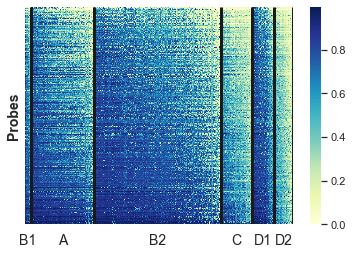

In [126]:
fig, ax = plt.subplots()

sns.heatmap(a[sorted_sample],xticklabels=True, cmap="YlGnBu")
# plt.xticks("''")
ax.tick_params(labelbottom=True,labelleft=False,labelright=False,labeltop=False)
labels = [len(B1)/2,len(B1)+len(A)/2,len(B1)+len(A)+len(B2)/2,len(B1)+len(A)+len(B2)+len(C)/2,len(B1)+len(A)+len(B2)+len(C)+len(D1)/2,len(B1)+len(A)+len(B2)+len(C)+len(D1)+len(D2)/2]
ax.set_xticks(labels)
# ax.set_xticklabels(["HRyoung","MYCNA","INSS4","INSS4s","LSA","LST"], rotation=-45, ha="left")
ax.set_xticklabels(["B1","A","B2","C","D1","D2"], rotation=0, size=14)

ax.set_yticks([])
ax.set_ylabel("Probes", size=14, weight="bold")

lw=3
ax.vlines(len(B1),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A)+len(B2),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A)+len(B2)+len(C),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A)+len(B2)+len(C)+len(D1),0,a.shape[0],"k",linewidth=lw)
ax.vlines(len(B1)+len(A)+len(B2)+len(C)+len(D1)+len(D2),0,a.shape[0],"k",linewidth=lw)
# plt.savefig(outdir+"heatmap_sorted.pdf", bbox_inches='tight')

plt.show()

# Fig S3

In [132]:
df_logrank = pd.read_csv(datadir+"beta_surv.csv", index_col=0)


In [128]:
a = df_beta
a = a.loc[a.mean(axis=1).sort_values(ascending=True).keys()]
sorted_sample = list(a[B1].mean().sort_values(ascending=False).keys())
sorted_sample.extend(list(a[A].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[B2].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[C].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[D1].mean().sort_values(ascending=False).keys()))
sorted_sample.extend(list(a[D2].mean().sort_values(ascending=False).keys()))

b=pd.DataFrame()
b["B1"] = a[B1].mean(axis=1)
b["C"] = a[C].mean(axis=1)
b["D1"] = a[D1].mean(axis=1)
b["D2"] = a[D2].mean(axis=1)
b["B1-C"] = b["B1"]-b["C"]
b["B1-D2"] = b["B1"]-b["D2"]
b = b.sort_values("B1-C")
b = b.sort_values("B1-D2")
b

,B1,C,D1,D2,B1-C,B1-D2
ID_REF,,,,,,
cg01253711,0.133971,0.379724,0.431229,0.567627,-0.245753,-0.433655
cg14521995,0.091857,0.668493,0.713406,0.511181,-0.576636,-0.419325
cg19595402,0.129903,0.384444,0.209070,0.531165,-0.254541,-0.401262
cg09462281,0.431159,0.793899,0.595655,0.782845,-0.362741,-0.351686
cg19082708,0.141569,0.325026,0.465403,0.469806,-0.183457,-0.328237
...,...,...,...,...,...,...
cg14018024,0.746342,0.499157,0.785131,0.304410,0.247186,0.441932
cg02939767,0.741669,0.429013,0.771507,0.292078,0.312656,0.449591
cg26232417,0.673892,0.318387,0.702097,0.201551,0.355505,0.472342


In [129]:
b["Relation_to_UCSC_CpG_Island"] = "-"
b["450k_Enhancer"] = "-"
for i,items in b.iterrows():
    b.at[i, "UCSC_RefGene_Name"] = df_anno.at[i, "UCSC_RefGene_Name"]
    b.at[i, "UCSC_RefGene_Accession"] = df_anno.at[i, "UCSC_RefGene_Accession"]
    b.at[i, "UCSC_RefGene_Group"] = df_anno.at[i, "UCSC_RefGene_Group"]
    b.at[i, "Relation_to_UCSC_CpG_Island"] = df_anno.at[i, "Relation_to_UCSC_CpG_Island"]
    b.at[i, "450k_Enhancer"] = df_anno.at[i, "450k_Enhancer"]
b

,B1,C,D1,D2,B1-C,B1-D2,Relation_to_UCSC_CpG_Island,450k_Enhancer,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group
ID_REF,,,,,,,,,,,
cg01253711,0.133971,0.379724,0.431229,0.567627,-0.245753,-0.433655,NaN,True,NaN,NaN,NaN
cg14521995,0.091857,0.668493,0.713406,0.511181,-0.576636,-0.419325,S_Shore,NaN,NaN,NaN,NaN
cg19595402,0.129903,0.384444,0.209070,0.531165,-0.254541,-0.401262,Island,True,SRCIN1,NM_025248,Body
cg09462281,0.431159,0.793899,0.595655,0.782845,-0.362741,-0.351686,Island,NaN,NCLN,NM_020170,Body
cg19082708,0.141569,0.325026,0.465403,0.469806,-0.183457,-0.328237,Island,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
cg14018024,0.746342,0.499157,0.785131,0.304410,0.247186,0.441932,N_Shelf,NaN,LAMC3,NM_006059,Body
cg02939767,0.741669,0.429013,0.771507,0.292078,0.312656,0.449591,NaN,NaN,TCF15,NM_004609,3'UTR
cg26232417,0.673892,0.318387,0.702097,0.201551,0.355505,0.472342,NaN,NaN,HNF4A;HNF4A;HNF4A;HNF4A;HNF4A;HNF4A,NM_000457;NM_001030003;NM_178849;NM_001030004;...,TSS1500;Body;TSS1500;Body;Body;TSS1500


In [133]:
for i,items in b.iterrows():
    b.at[i, "mean_FDR"] = df_logrank.at[i, "mean_FDR"]
    b.at[i, "median_FDR"] = df_logrank.at[i, "median_FDR"]
    b.at[i, "upper_mean_EFS"] = df_logrank.at[i, "upper_mean_EFS"]
    b.at[i, "lower_mean_EFS"] = df_logrank.at[i, "lower_mean_EFS"]
    b.at[i, "upper_median_beta"] = df_logrank.at[i, "upper_median_beta"]
    b.at[i, "lower_median_beta"] = df_logrank.at[i, "lower_median_beta"]
    

In [134]:
b = b.loc[(b["mean_FDR"]!=1)]


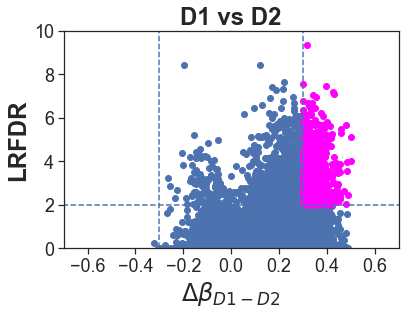

In [142]:
sns.set_style('ticks')

fig, ax = plt.subplots()

tmp2 = b.loc[(b["mean_FDR"]>0.01) | (abs(b["D1"]-b["D2"])<0.3)]
plt.scatter(tmp2["D1"]-tmp2["D2"], -log10(tmp2["mean_FDR"]))
tmp1 = b.loc[(b["mean_FDR"]<0.01) & (abs(b["D1"]-b["D2"])>0.3)]
plt.scatter(tmp1["D1"]-tmp1["D2"], -log10(tmp1["mean_FDR"]), color="magenta")


# plt.scatter(b["D1"]-b["D2"], -log10(b["mean_FDR"]))
ax.hlines(y=2, xmin=-1, xmax=1, linestyles='dashed')
ax.vlines(x=0.3, ymin=0, ymax=10, linestyles='dashed')
ax.vlines(x=-0.3, ymin=0, ymax=10, linestyles='dashed')
# plt.hline(2,(-1,1))
plt.xlim([-.7,.7])
plt.ylim([0,10])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"$\Delta\beta_{D1-D2}$", size=24, weight="bold")
plt.ylabel("LRFDR", size=24, weight="bold")
plt.title("D1 vs D2", size=24, weight="bold")
plt.savefig(outdir+"D1D2.png", bbox_inches='tight')
plt.show()

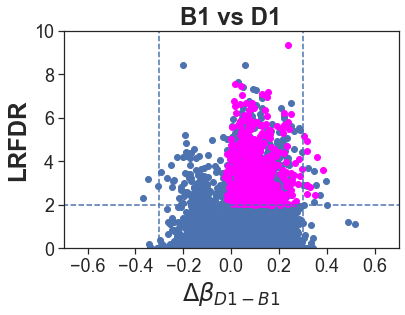

In [143]:
fig, ax = plt.subplots()

# tmp = b.loc[(b["mean_FDR"]<0.01) & (abs(b["B1"]-b["D1"])>0.3)]
tmp2 = b.loc[(b["mean_FDR"]>0.01) | (abs(b["D1"]-b["D2"])<0.3)]
plt.scatter(tmp2["D1"]-tmp2["B1"], -log10(tmp2["mean_FDR"]))
tmp1 = b.loc[(b["mean_FDR"]<0.01) & (abs(b["D1"]-b["D2"])>0.3)]
plt.scatter(tmp1["D1"]-tmp1["B1"], -log10(tmp1["mean_FDR"]), color="magenta")

# plt.scatter(b["B1"]-b["D1"], -log10(b["mean_FDR"]))
ax.hlines(y=2, xmin=-1, xmax=1, linestyles='dashed')
ax.vlines(x=0.3, ymin=0, ymax=10, linestyles='dashed')
ax.vlines(x=-0.3, ymin=0, ymax=10, linestyles='dashed')
# plt.hline(2,(-1,1))
plt.xlim([-.7,.7])
plt.ylim([0,10])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"$\Delta \beta_{D1-B1}$", size=24, weight="bold")
plt.ylabel("LRFDR", size=24, weight="bold")
plt.title("B1 vs D1", size=24, weight="bold")
plt.savefig(outdir+"B1D1.png", bbox_inches='tight')
plt.show()

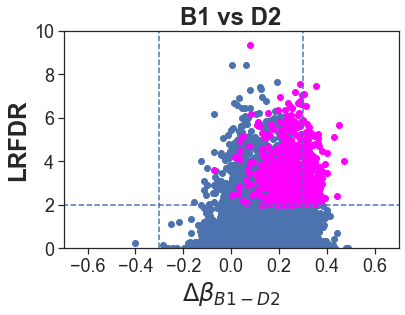

In [145]:
fig, ax = plt.subplots()

tmp2 = b.loc[(b["mean_FDR"]>0.01) | (abs(b["D1"]-b["D2"])<0.3)]
plt.scatter(tmp2["B1"]-tmp2["D2"], -log10(tmp2["mean_FDR"]))
tmp1 = b.loc[(b["mean_FDR"]<0.01) & (abs(b["D1"]-b["D2"])>0.3)]
plt.scatter(tmp1["B1"]-tmp1["D2"], -log10(tmp1["mean_FDR"]), color="magenta")

ax.hlines(y=2, xmin=-1, xmax=1, linestyles='dashed')
ax.vlines(x=0.3, ymin=0, ymax=10, linestyles='dashed')
ax.vlines(x=-0.3, ymin=0, ymax=10, linestyles='dashed')
# plt.hline(2,(-1,1))
plt.xlim([-.7,.7])
plt.ylim([0,10])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"$\Delta\beta_{B1-D2}$", size=24, weight="bold")
plt.ylabel("LRFDR", size=24, weight="bold")
plt.title("B1 vs D2", size=24, weight="bold")
plt.savefig(outdir+"B1D2.png", bbox_inches='tight')
plt.show()

In [7]:
1773*100/60/60

49.25

In [ ]:
df = pd.read_csv("")